## Imports

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en
!unzip speech-emotion-recognition-en.zip

cp: cannot stat '/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open speech-emotion-recognition-en.zip, speech-emotion-recognition-en.zip.zip or speech-emotion-recognition-en.zip.ZIP.


In [32]:
import pandas as pd
import numpy as np
from IPython.display import Audio
import os
import zipfile
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
import keras
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D, MaxPooling2D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## classify dataset into classes

In [3]:
# classify crema dataset into classes according to their emotions
audio_path = []
audio_emotion = []
path = '/kaggle/input/speech-emotion-recognition-en/Crema/'
directory_path = os.listdir(path)
# collects all the audio filename in the variable 'path'
# directory_path = sorted(os.listdir(path))
print(len(directory_path))
for audio in directory_path:
    if audio.endswith('zip'):
      continue
    else:
      audio_path.append(path + "/"+audio)
      emotion = audio.split('_')
      if emotion[2] == 'SAD':
          audio_emotion.append("sad")
      elif emotion[2] == 'ANG':
          audio_emotion.append("angry")
      elif emotion[2] == 'DIS':
          audio_emotion.append("disgust")
      elif emotion[2] == 'NEU':
          audio_emotion.append("neutral")
      elif emotion[2] == 'HAP':
          audio_emotion.append("happy")
      elif emotion[2] == 'FEA':
          audio_emotion.append("fear")
      else:
          audio_emotion.append("unknown")
#dataframe for labels
emotion_dataset = pd.DataFrame(audio_emotion, columns=['Emotions'])
#dataframe for audios
audio_path_dataset = pd.DataFrame(audio_path, columns=['Path'])
#dataframe for audio with its labels
dataset = pd.concat([audio_path_dataset, emotion_dataset], axis= 1)
print(dataset)

7442
                                                   Path Emotions
0     /kaggle/input/speech-emotion-recognition-en/Cr...  disgust
1     /kaggle/input/speech-emotion-recognition-en/Cr...    happy
2     /kaggle/input/speech-emotion-recognition-en/Cr...    happy
3     /kaggle/input/speech-emotion-recognition-en/Cr...  disgust
4     /kaggle/input/speech-emotion-recognition-en/Cr...  disgust
...                                                 ...      ...
7437  /kaggle/input/speech-emotion-recognition-en/Cr...    angry
7438  /kaggle/input/speech-emotion-recognition-en/Cr...    angry
7439  /kaggle/input/speech-emotion-recognition-en/Cr...    angry
7440  /kaggle/input/speech-emotion-recognition-en/Cr...      sad
7441  /kaggle/input/speech-emotion-recognition-en/Cr...      sad

[7442 rows x 2 columns]


## Load data

In [4]:
#load audios
audio_arrays = []
# signal variable contains the waveform as 1-dimensional NumPy array
# sr is the sampling rate of the audio
for i in dataset['Path']:
    x, sr = librosa.load(i)   
    audio_arrays.append(x)

In [5]:
max=0
for i in range(7442):
    if len(audio_arrays[i])>max:
        max = len(audio_arrays[i])
print(max)

110361


In [6]:
for i in range(7442):
  if len(audio_arrays[i]) < max:
    difference = max - len(audio_arrays[i])
    # padding array using CONSTANT mode
    audio_arrays[i] = np.pad(audio_arrays[i], (0, difference), 'constant')

In [7]:
dataset['Arrays'] = audio_arrays

###Splitting Data:

In [8]:
#70% train & validation ,30% test
xtrain, xtest, ytrain, ytest = train_test_split(audio_arrays,audio_emotion, test_size=0.3,stratify=audio_emotion,random_state=42)
#95% train & 5% validation
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, test_size=0.05,stratify=ytrain,random_state=42)

## listen and plot audio

In [9]:
#function for listen and plot waveform audio
def lisandplot(y,emotion):
  audio_file_path=dataset[dataset['Emotions']==emotion]['Path'].iloc[y]
  array=dataset[dataset['Emotions']==emotion]['Arrays'].iloc[y]
  name=audio_file_path.split("/") 
  print("audio name:",name[5],"\n")
  audio=Audio(audio_file_path, autoplay=True)
  display(audio)
  # Plot the waveform
  plt.figure(figsize=(14, 5))
  plt.plot(array)
  plt.xlabel('Sample Index')
  plt.ylabel('Amplitude')
  plt.title('Waveform of Audio File')
  plt.show()

audio name:  



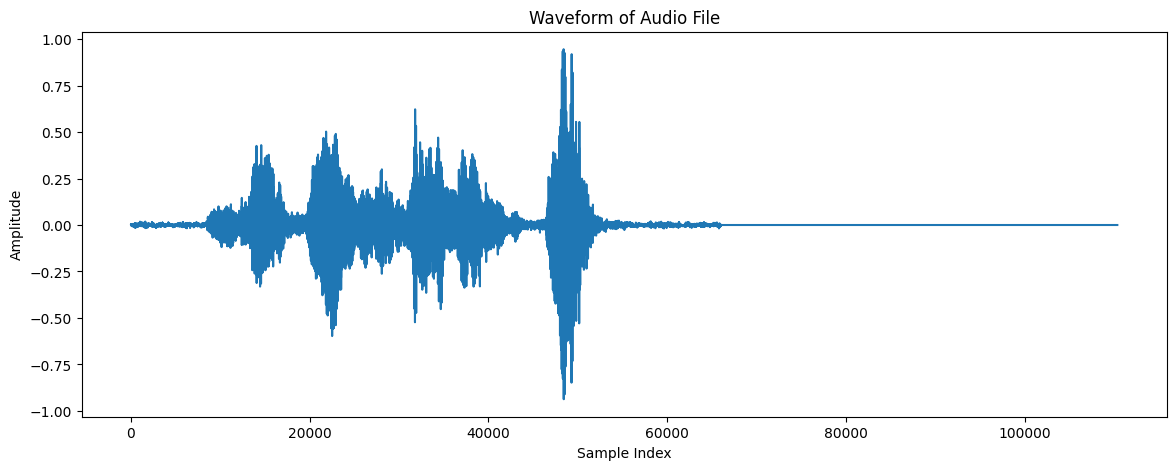

In [11]:
#angry
lisandplot(0,'angry')

audio name:  



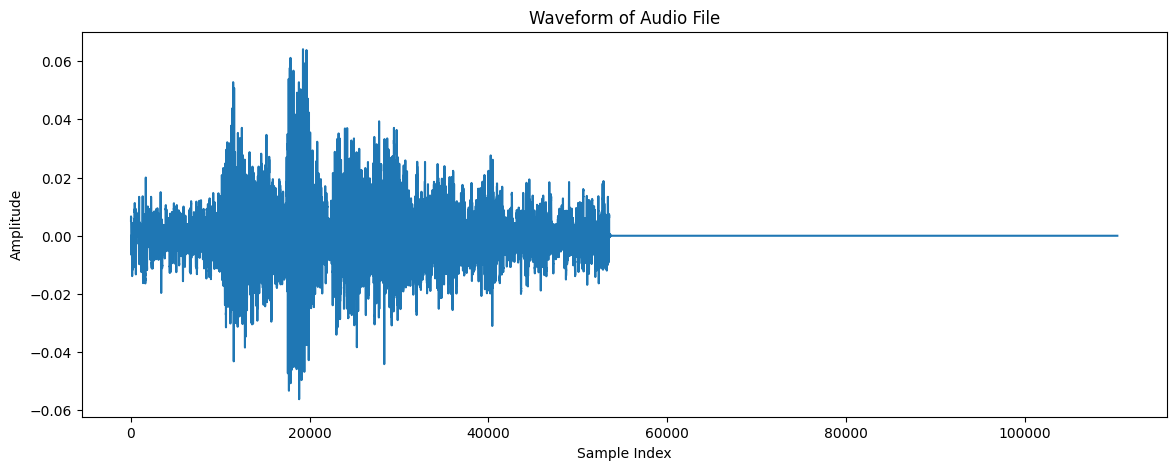

In [12]:
#disgust
lisandplot(0,'disgust')

audio name:  



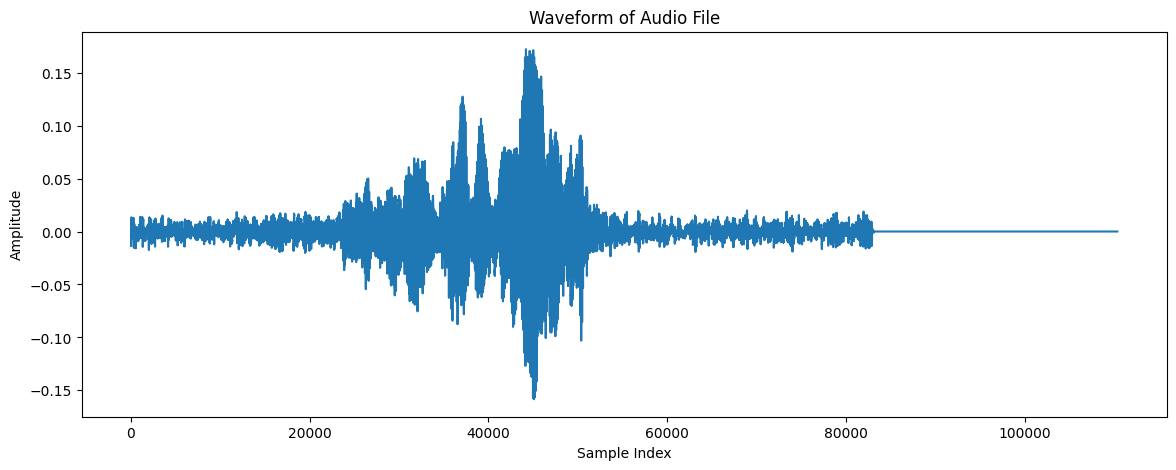

In [13]:
#fear
lisandplot(0,'fear')

audio name:  



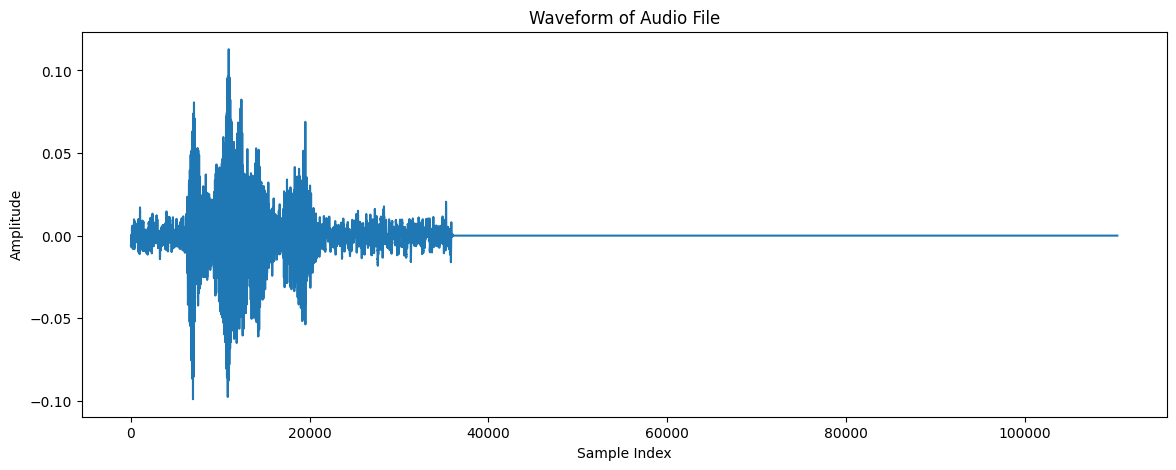

In [14]:
#happy
lisandplot(0,'happy')

audio name:  



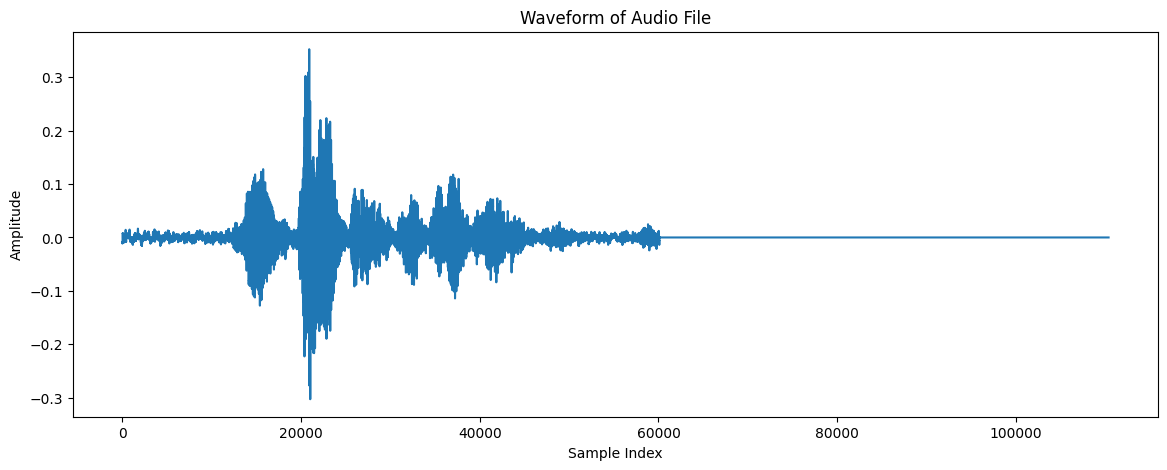

In [15]:
#neutral
lisandplot(0,'neutral')

audio name:  



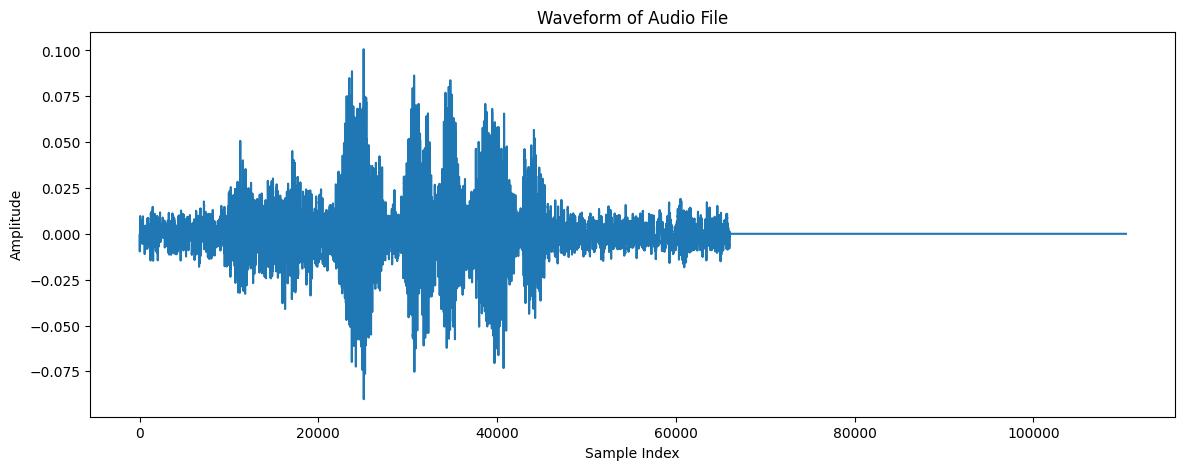

In [16]:
#sad
lisandplot(0,'sad')

## Feature Space

In [10]:
def find_FS(audio):
  #audio in time domain
  # Zero crossing rate
  zcr = librosa.feature.zero_crossing_rate(audio).T

  # MelSpectogram
  #n_ftt -> length of fft window
  #sr -> sampling rate
  mel =librosa.feature.melspectrogram(y=audio, sr=sr)
  #spectrogram = np.abs(mel)
  #In spectrogram most of the frequencies contribute very little to the overall amplitude of the sound.
  #A way to visualize loudness, which is not linear but logarithmic, is to convert our spectrograms 
  #from amplitude to decibels.
#   power_to_db = librosa.power_to_db(mel, ref=np.max)
  
  # Energy
  frame_length=2048
  hop_length=512
  energy = np.array([np.sum(np.power(np.abs(audio[hop:hop+frame_length]), 2)) for hop in range(0, audio.shape[0], hop_length)])
  normalized_energy = energy/frame_length
  
  # feature_space = pd.concat([zcrDF,energyDF], axis= 1)
  feature_space=np.append(zcr,normalized_energy)
  return mel, feature_space

In [11]:
def getFeatures(data):
  y = []
  melSpec=[]
  time=[]
  dp_melSpec=[]
  for i in range(len(data)):
        mel,dp,features=find_FS(data[i]);
        melSpec.append(mel)     #melspectogram (second feature)
#         dp_melSpec.append(dp) #melspectogram (in dp)
        time.append(features)   #zero crossing rate &energy(first feature)
  return np.array(melSpec), np.array(time)

In [12]:
xtrain_spec, xtrain_time  = getFeatures(xtrain)
xvalid_spec, xvalid_time  = getFeatures(xvalid)
xtest_spec, xtest_time  = getFeatures(xtest)

In [13]:
def shape(arr):
  arr = arr.reshape((arr.shape[0], 1))
  arr = encoder.fit_transform(np.array(arr).reshape(-1,1)).toarray()
  return arr

In [14]:
encoder = OneHotEncoder()
ytrain=shape(np.array(ytrain))
ytest=shape(np.array(ytest))
yvalid=shape(np.array(yvalid))

In [15]:
xtrain_time = xtrain_time.reshape((xtrain_time.shape[0],xtrain_time.shape[1], 1))
xtest_time = xtest_time.reshape((xtest_time.shape[0],xtest_time.shape[1], 1))
xvalid_time = xvalid_time.reshape((xvalid_time.shape[0],xvalid_time.shape[1],1))
xtrain_spec = xtrain_spec.reshape((xtrain_spec.shape[0],xtrain_spec.shape[1],xtrain_spec.shape[2], 1))
xvalid_spec = xvalid_spec.reshape((xvalid_spec.shape[0],xvalid_spec.shape[1],xvalid_spec.shape[2], 1))
xtest_spec = xtest_spec.reshape((xtest_spec.shape[0],xtest_spec.shape[1],xtest_spec.shape[2], 1))

In [16]:
print((xtrain_time.shape, ytrain.shape, xtest_time.shape, ytest.shape, xvalid_time.shape, yvalid.shape))
print((xtrain_spec.shape, ytrain.shape, xtest_spec.shape, ytest.shape, xvalid_spec.shape, yvalid.shape))

((4948, 432, 1), (4948, 6), (2233, 432, 1), (2233, 6), (261, 432, 1), (261, 6))
((4948, 128, 216, 1), (4948, 6), (2233, 128, 216, 1), (2233, 6), (261, 128, 216, 1), (261, 6))


### 1D Cnn Model (Time domain)

In [46]:
model_1d=Sequential()

#1st layer
model_1d.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(xtrain_time.shape[1], 1)))
# model_1d.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model_1d.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))

#2nd layer
model_1d.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model_1d.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model_1d.add(Dropout(0.2)) 

#3rd layer
model_1d.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model_1d.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))

# Flatten the output to a 1D vector 
model_1d.add(Flatten())
# Add a fully connected layer with 64 units and ReLU activation
model_1d.add(Dense(units = 64, activation='relu'))
# dropout layer used to reduce overfitting by 20% ratio
model_1d.add(Dropout(0.2)) 
# Add another fully connected layer with 32 units and ReLU activation(It determines the number of neurons or units in the layer)
model_1d.add(Dense(units = 32, activation='relu')) 
# Add the output layer with 6 units (corresponding to the number of classes) and softmax activation
model_1d.add(Dense(units = 6, activation='softmax'))
model_1d.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model_1d.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 432, 512)          3072      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 216, 512)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 216, 128)          327808    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 108, 128)         0         
 1D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 108, 128)          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 108, 64)         

In [47]:
history=model_1d.fit(xtrain_time, ytrain, batch_size=32, epochs=30, validation_data=(xvalid_time, yvalid))

Epoch 1/30
155/155 [==============================] - 32s 13ms/step - loss: 1.7200 - accuracy: 0.2508 - val_loss: 1.6149 - val_accuracy: 0.3142
Epoch 2/30
155/155 [==============================] - 2s 12ms/step - loss: 1.5839 - accuracy: 0.3385 - val_loss: 1.5434 - val_accuracy: 0.3563
Epoch 3/30
155/155 [==============================] - 2s 11ms/step - loss: 1.5131 - accuracy: 0.3618 - val_loss: 1.5059 - val_accuracy: 0.3563
Epoch 4/30
155/155 [==============================] - 2s 12ms/step - loss: 1.4862 - accuracy: 0.3884 - val_loss: 1.4632 - val_accuracy: 0.3831
Epoch 5/30
155/155 [==============================] - 2s 11ms/step - loss: 1.4695 - accuracy: 0.3919 - val_loss: 1.4726 - val_accuracy: 0.3946
Epoch 6/30
155/155 [==============================] - 2s 12ms/step - loss: 1.4457 - accuracy: 0.4056 - val_loss: 1.5007 - val_accuracy: 0.3640
Epoch 7/30
155/155 [==============================] - 2s 12ms/step - loss: 1.4261 - accuracy: 0.4123 - val_loss: 1.4210 - val_accuracy: 0.410

70/70 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.66      0.71      0.68       382
           1       0.43      0.29      0.34       381
           2       0.36      0.21      0.27       381
           3       0.44      0.33      0.38       382
           4       0.37      0.58      0.45       326
           5       0.45      0.64      0.53       381

    accuracy                           0.46      2233
   macro avg       0.45      0.46      0.44      2233
weighted avg       0.45      0.46      0.44      2233



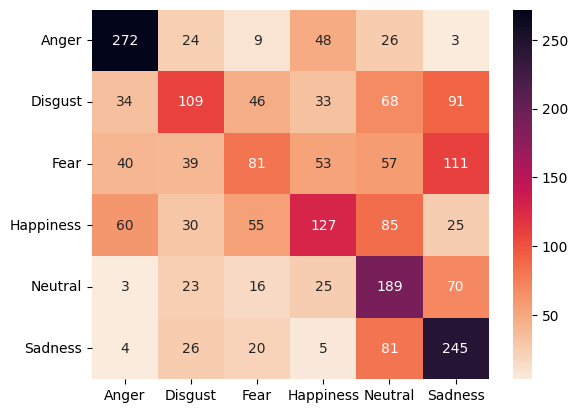

In [48]:
y_pred_time = model_1d.predict(xtest_time)
matrix_time = confusion_matrix(ytest.argmax(axis=1), y_pred_time.argmax(axis=1))
ax = sns.heatmap(matrix_time, annot=True, fmt="d", cmap = 'rocket_r',
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])
print(classification_report(ytest.argmax(axis=1), y_pred_time.argmax(axis=1)))

## 2D cnn Model

In [55]:
model2= keras.Sequential()

model2.add(Conv2D(256, kernel_size=3, strides=1, padding='same',
                 activation='relu', input_shape=(xtrain_spec.shape[1], xtrain_spec.shape[2], 1)))
model2.add(MaxPooling2D(pool_size=2, strides = 2, padding = 'same'))

model2.add(Conv2D(128, kernel_size=4, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2, strides = 2, padding = 'same'))

model2.add(Conv2D(64, kernel_size=4, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2, strides = 2, padding = 'same'))
# model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(units=6, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 128, 216, 256)     2560      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 64, 108, 256)     0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 108, 128)      524416    
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 32, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 54, 64)        131136    
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 16, 27, 64)     

In [56]:
# Train model
history = model2.fit(xtrain_spec, ytrain, validation_data=(xvalid_spec, yvalid), batch_size=32, epochs=25)

Epoch 1/25
155/155 [==============================] - 33s 209ms/step - loss: 1.8386 - accuracy: 0.3066 - val_loss: 1.6452 - val_accuracy: 0.3257
Epoch 2/25
155/155 [==============================] - 32s 206ms/step - loss: 1.5592 - accuracy: 0.3511 - val_loss: 1.5462 - val_accuracy: 0.3487
Epoch 3/25
155/155 [==============================] - 32s 206ms/step - loss: 1.5293 - accuracy: 0.3616 - val_loss: 1.6076 - val_accuracy: 0.3985
Epoch 4/25
155/155 [==============================] - 32s 205ms/step - loss: 1.5011 - accuracy: 0.3899 - val_loss: 1.5531 - val_accuracy: 0.3793
Epoch 5/25
155/155 [==============================] - 32s 207ms/step - loss: 1.4609 - accuracy: 0.3931 - val_loss: 1.5698 - val_accuracy: 0.4023
Epoch 6/25
155/155 [==============================] - 32s 205ms/step - loss: 1.4247 - accuracy: 0.4161 - val_loss: 1.5274 - val_accuracy: 0.4100
Epoch 7/25
155/155 [==============================] - 32s 205ms/step - loss: 1.4291 - accuracy: 0.4218 - val_loss: 1.5709 - val_ac

70/70 [==============================] - 3s 38ms/step
              precision    recall  f1-score   support

           0       0.58      0.64      0.61       382
           1       0.44      0.35      0.39       381
           2       0.45      0.24      0.31       381
           3       0.38      0.40      0.39       382
           4       0.40      0.61      0.48       326
           5       0.52      0.57      0.54       381

    accuracy                           0.46      2233
   macro avg       0.46      0.47      0.45      2233
weighted avg       0.46      0.46      0.45      2233



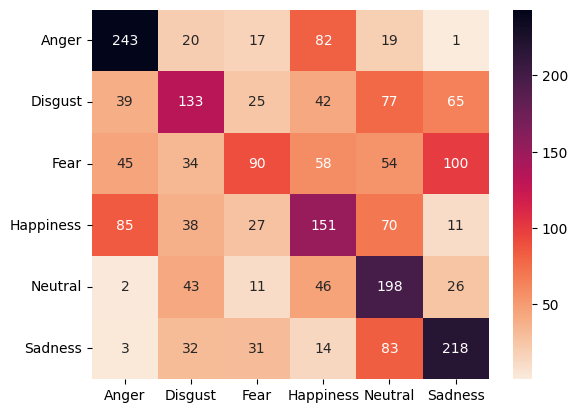

In [57]:
y_pred_spec = model2.predict(xtest_spec)
matrix_spec = confusion_matrix(ytest.argmax(axis=1), y_pred_spec.argmax(axis=1))
ax = sns.heatmap(matrix_spec, annot=True, fmt="d", cmap = 'rocket_r',
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])
print(classification_report(ytest.argmax(axis=1), y_pred_spec.argmax(axis=1)))